In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
%matplotlib inline

In [2]:
# Load datasets
# Make sure the .csv files are in the same directory as this notebook
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)

# Class mapping based on MIT-BIH standards
class_names = {0: 'N (Normal)', 1: 'S (Supraventricular)', 2: 'V (Ventricular)', 3: 'F (Fusion)', 4: 'Q (Unknown)'}

# Display class distribution
print("Original Class Distribution (Train Set):")
print(train_df[187].value_counts().rename(index=class_names))

Original Class Distribution (Train Set):
187
N (Normal)              72471
Q (Unknown)              6431
V (Ventricular)          5788
S (Supraventricular)     2223
F (Fusion)                641
Name: count, dtype: int64


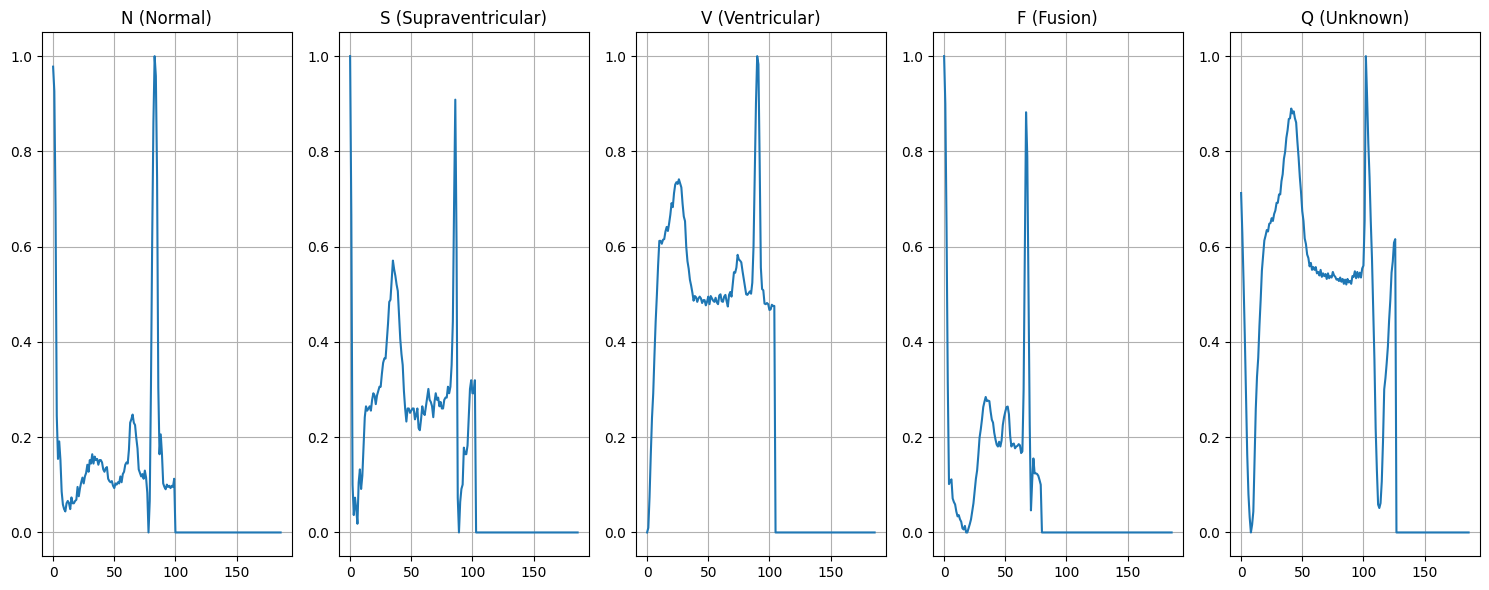

In [3]:
# Visualize one sample from each class
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Get the first sample of class i
    sample = train_df[train_df[187] == i].iloc[0, :187]
    plt.plot(sample)
    plt.title(class_names[i])
    plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Separate classes
df_0 = train_df[train_df[187] == 0]
df_1 = train_df[train_df[187] == 1]
df_2 = train_df[train_df[187] == 2]
df_3 = train_df[train_df[187] == 3]
df_4 = train_df[train_df[187] == 4]

# Target samples per class
n_samples = 20000

# Resample (Upsample minority, Downsample majority)
df_0_downsampled = resample(df_0, replace=False, n_samples=n_samples, random_state=127)
df_1_upsampled = resample(df_1, replace=True, n_samples=n_samples, random_state=123)
df_2_upsampled = resample(df_2, replace=True, n_samples=n_samples, random_state=124)
df_3_upsampled = resample(df_3, replace=True, n_samples=n_samples, random_state=125)
df_4_upsampled = resample(df_4, replace=True, n_samples=n_samples, random_state=126)

# Concatenate back
train_balanced = pd.concat([df_0_downsampled, df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled])

# Shuffle the dataset
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Class Distribution:")
print(train_balanced[187].value_counts())

Balanced Class Distribution:
187
3.0    20000
4.0    20000
0.0    20000
2.0    20000
1.0    20000
Name: count, dtype: int64


In [5]:
# Split features and labels
X_train = train_balanced.iloc[:, :187].values
y_train = train_balanced.iloc[:, 187].values

X_test = test_df.iloc[:, :187].values
y_test = test_df.iloc[:, 187].values

# Standardization
# Logistic Regression converges faster and performs better with scaled data
scaler = StandardScaler()

print("Scaling data...")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data shape:", X_train_scaled.shape)

Scaling data...
Data shape: (100000, 187)


In [6]:
# Initialize Logistic Regression
# solver='saga' is efficient for large datasets and supports multinomial loss
# n_jobs=-1 uses all CPU cores
log_reg = LogisticRegression(multi_class='multinomial', 
                             solver='saga', 
                             max_iter=1000, 
                             verbose=1, 
                             n_jobs=-1,
                             random_state=42)

print("Training started...")
log_reg.fit(X_train_scaled, y_train)
print("Training finished.")

Training started...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 1004 seconds
Training finished.



--- CLASSIFICATION REPORT ---
                      precision    recall  f1-score   support

          N (Normal)       0.97      0.65      0.78     18118
S (Supraventricular)       0.15      0.66      0.24       556
     V (Ventricular)       0.30      0.72      0.42      1448
          F (Fusion)       0.08      0.87      0.15       162
         Q (Unknown)       0.73      0.91      0.81      1608

            accuracy                           0.68     21892
           macro avg       0.45      0.76      0.48     21892
        weighted avg       0.88      0.68      0.74     21892



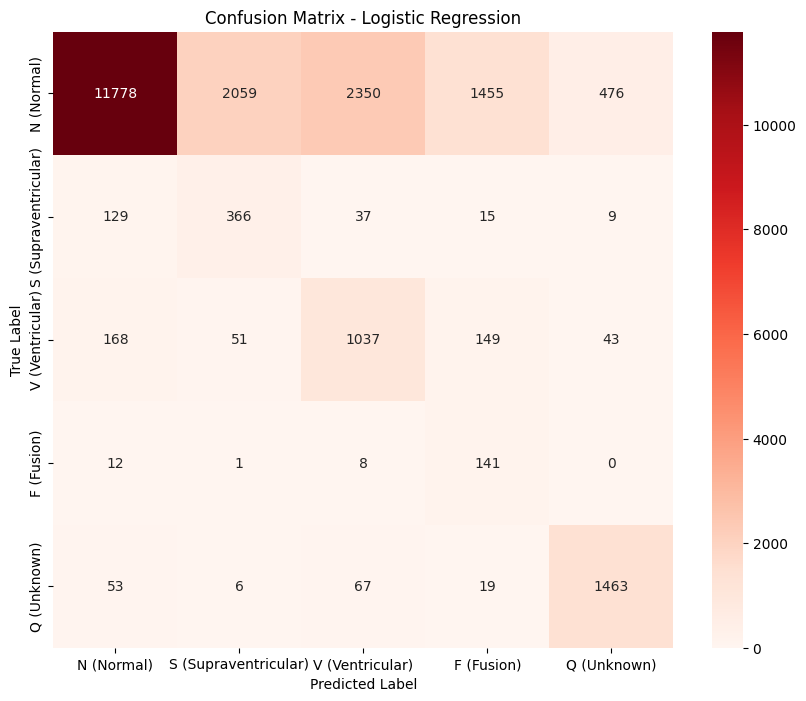

In [8]:
# Predict on Test set
y_pred = log_reg.predict(X_test_scaled)

# Generate Classification Report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=list(class_names.values())))

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=list(class_names.values()), 
            yticklabels=list(class_names.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()